# PreTP 2 - Grafos en neurociencia


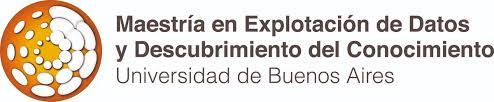

**_Data mining en Ciencia y Tecnología_**  
2do cuatrimestre 2023

[Víctor A. Bettachini](mailto:bettachini@gmail.com)  
2023-10-24

## 4. Preprocesamiento de datos

### Carga datos
Cargar el dataset con los datos para cada sujeto y los nombres y coordenadas de las
regiones cerebrales a las que se les registró la actividad.

In [1]:
from pathlib import Path
if not Path("./DataSujetos").is_dir():
  ! wget -q https://www.dropbox.com/s/eei6gnw10o20mcn/DataSujetos.zip?dl=1 -O DataSujetos.zip
  ! unzip -q DataSujetos
  ! rm DataSujetos.zip

In [2]:
if not Path("./aal_extended_withCoords.csv").exists():
  ! wget -q "https://www.dropbox.com/scl/fi/pu1qdch4c3khk0uol9l0w/aal_extended_withCoords.csv?rlkey=bsnfot3b9ycp7slble59e1cws&dl=1n" -O aal_extended_withCoords.csv

### Descrición de los datos
Reportar cuántos sujetos y cuántos estados de sueño se observan en el conjunto de
datos.

Sujetos = 18  
Estados de sueño 4 condiciones, una correspondiente a vigilia y 3 a diferentes estadios del sueño no REM (*rapid eye movement*):  
- "W": despierto ("Wake")  
- "N1": sueño "leve"  
- "N2": sueño "intermedio"  
- "N3": sueño "profundo"  

## 5. Manipulación de datos

### Correlaciones entre regiones
Graficar la matriz de correlaciones entre regiones (es decir, la "matriz de adyacencia
pesada") para el sujeto 2 de la condición despierto ("Wake")

In [3]:
import pandas as pd
import numpy as np

In [4]:
filename = './DataSujetos/W_suj2.csv'
df = pd.read_csv(filename, header=None)
matAdyacPesada = df.values
n = matAdyacPesada.shape[0]
matAdyacPesada -= np.diag(np.ones(n))

In [5]:
try:
  import seaborn as sns
  import matplotlib.pyplot as plt
except:
  ! pip install -q seaborn
  import seaborn as sns
  import matplotlib.pyplot as plt

(0.0, 116.0)

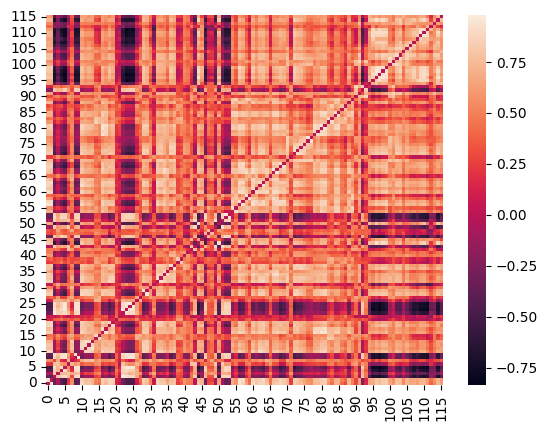

In [6]:
sns.heatmap(matAdyacPesada)
plt.xlim(0,n)
plt.ylim(0,n)

### Correlación entre regiones
Seleccionar un umbral de correlación entre regiones.
Transformar dicha matriz de adyacencia pesada a una matriz de adyancia binaria $A_{i,j}$ que represente una densidad de enlaces $\delta = 0.08$.
¿Cuál es el valor de umbral de correlación entre pares de regiones que tuvo que utilizar?

Repaso de definiciones
- grado, es el número de enlaces del nodo i, $k_i = \sum_{j=1}^n A_{i,j}$ siendo $n$ el número de nodos
- el número total de enlaces $m = \frac{1}{2} \sum_{i=1}^n k_i = \frac{1}{2} \sum_{i=1}^n \sum_{j=1}^n A_{i,j}$, para grafos no dirigidos (el medio es porque se cuenta doble)
- densidad $\rho = \frac{2 m}{n (n-1)}$

A prueba y error.

In [50]:
# Prueba y error  
th = 0.779970
matAdyacNoPesada = (matAdyacPesada >= th)
n = len(matAdyacNoPesada)
densidad = sum(sum(matAdyacNoPesada))/ (n* (n-1))
densidad

0.0800599700149925

El umbral para lograr una densidad de enlaces de $\delta \approx 0.08$ es 0.779.

Con la función provista en clase

In [7]:
def density_to_th(W, d):
    n=W.shape[0]
    max_links = (n*(n-1))//2
    tril_idx = np.tril_indices(n,-1)
    c = sorted(np.array(list(W[tril_idx].reshape(-1))), reverse=True)
    return c[int((len(c)-1)*d)]

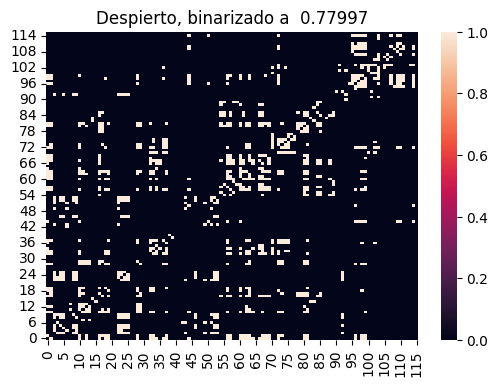

In [8]:
matAdyacPesadaWake = matAdyacPesada.copy()
densidad = 0.08 # comparemos ambos estados con una densidad de enlaces de 10%

plt.figure(figsize=(6,4))

thWake = density_to_th(matAdyacPesadaWake, densidad)
sns.heatmap(matAdyacPesadaWake >= thWake)
plt.xlim(0,n)
plt.ylim(0,n);
plt.title(f'Despierto, binarizado a {thWake}')
plt.show()

### Grafo y lista de enlaces
Utilizando Ai,j , obtener el grafo resultante G y la lista de enlaces de dicho grafo

In [11]:
try:
  import networkx as nx
except:
  ! pip install networkx
  import networkx as nx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 279.2 kB/s eta 0:00:001m270.7 kB/s eta 0:00:01


In [12]:
G = nx.from_numpy_array(matAdyacNoPesada)

En este grafo están estos enlaces (edges):

In [13]:
G.edges()

EdgeView([(0, 1), (0, 10), (0, 12), (0, 16), (0, 18), (0, 19), (0, 28), (0, 32), (0, 33), (0, 34), (0, 36), (0, 37), (0, 44), (0, 56), (0, 57), (0, 60), (0, 61), (0, 62), (0, 63), (0, 64), (0, 66), (0, 67), (0, 68), (0, 69), (0, 72), (0, 80), (0, 81), (0, 96), (0, 98), (0, 99), (1, 10), (1, 12), (1, 16), (1, 17), (1, 18), (1, 19), (1, 28), (1, 32), (1, 33), (1, 37), (1, 56), (1, 57), (1, 60), (1, 61), (1, 62), (1, 63), (1, 67), (1, 68), (1, 69), (1, 72), (1, 73), (1, 80), (1, 81), (1, 96), (1, 98), (1, 99), (2, 3), (2, 4), (2, 5), (2, 8), (2, 9), (2, 22), (2, 23), (2, 24), (2, 25), (2, 43), (2, 49), (2, 51), (2, 52), (2, 53), (2, 92), (3, 6), (3, 9), (3, 22), (3, 23), (4, 5), (4, 8), (4, 9), (4, 22), (4, 23), (4, 24), (4, 25), (4, 46), (4, 52), (4, 53), (5, 8), (5, 9), (5, 22), (5, 23), (5, 24), (5, 25), (5, 46), (5, 52), (5, 53), (5, 92), (6, 42), (6, 43), (6, 49), (6, 51), (7, 11), (7, 13), (8, 9), (8, 22), (8, 23), (8, 24), (8, 25), (8, 46), (8, 52), (8, 53), (8, 92), (9, 22), (9, 2

La cantidad de los mismos es 

In [14]:
G.number_of_edges()

538

### Visualización del grafo
Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada
nodo de acuerdo a su coeficiente de clustering $C_i$

In [15]:
# Carga de coordenadas de regiones
RegionsNames = pd.read_csv("aal_extended_withCoords.csv", header=None).iloc[:,1:]

Entiendo el coeficiente $C_i = \frac{k_i}{\mathrm{máx} (k_i)}$

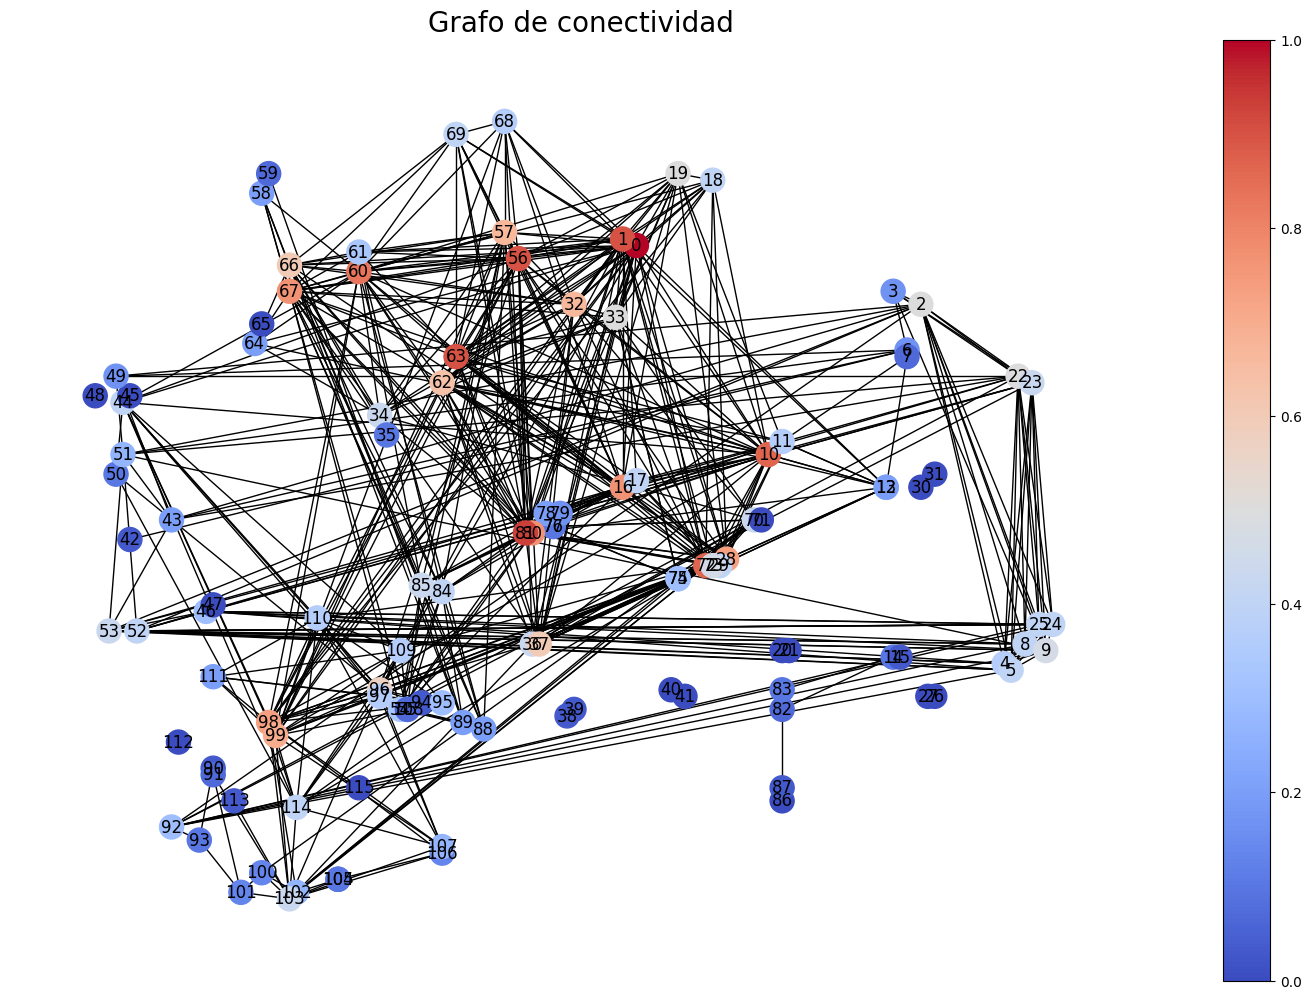

In [70]:
degrees = G.degree() # Diccionario con ID de nodo y su grado
nodes = G.nodes()
n_color = np.asarray([degrees[n] for n in nodes])

# Visualizar el grafo, ubicando los nodos en sus coordenadas cerebrales y coloreando cada nodo de acuerdo a su coeficiente de clustering Ci
fig, ax = plt.subplots(figsize=(15,10))
fig.tight_layout()
ax.title.set_text('Grafo de conectividad')
ax.title.set_fontsize(20)

layout = dict(zip(range(n),np.array([RegionsNames[6].values, RegionsNames[7].values]).T))

max_degrees = max(n_color)
n_color = n_color/max_degrees

vmin = min(n_color)
vmax = max(n_color)
color_map = plt.cm.coolwarm
nx.draw(G, layout, node_color = n_color, with_labels = True, node_size = 300,
  cmap = color_map,
  vmin = vmin, vmax = vmax)
sm = plt.cm.ScalarMappable(cmap = color_map, norm = plt.Normalize(vmin = vmin, vmax = vmax))
cbar = plt.colorbar(sm, ax=ax)

### Distribución de grados
Graficar la distribución de grado del grafo, elijiendo un número de bins apropriado

Text(0.5, 1.0, 'Distribucion de grados, despierto')

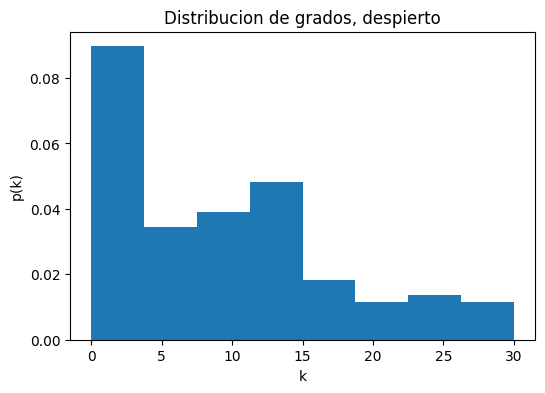

In [74]:
plt.figure(figsize=(6,4))
Gwake = nx.from_numpy_array(matAdyacPesadaWake >= thWake)
degreesWake = [Gwake.degree(n) for n in Gwake.nodes()]
plt.hist(degreesWake , bins = 8, density = True)
plt.xlabel('k')
plt.ylabel('p(k)')
plt.title('Distribucion de grados, despierto')

### Grado promedio
Calcular el grado promedio $\langle k \rangle$, el nodo con grado máximo $k_\text{máx}$, el coeficiente de clustering promedio $C = \langle C_i \rangle$ y la distancia media entre pares de nodos $d$ del grafo.

In [98]:
k_promedio = np.mean(n_color* max_degrees)
print("k medio =", k_promedio)

k medio = 9.275862068965518


In [85]:
print("k máximo =",  max_degrees)

k máximo = 30


In [87]:
print("C=", np.mean(n_color) )

0.3091954022988505

### Comparación con otras redes

Comparar lo obtenido con prototipos de redes poissonianas, small-World y scale-free, usando los algoritmos de Erdos-Renyi, Watts-Strogatz y Barabasi-Albert, respectivamente.
Elegir (y reportar) los parámetros utilizdos para cada algoritmo, buscando siempre que los grafos simulados sean comparables al grafo de datos G (en términos de número de nodos y números de enlaces).
Visualizar un ejemplo de grafo para cada uno de estos prototipos de redes.
Discutir diferencias.

In [ ]:
import os

In [ ]:
files = os.listdir('DataSujetos/')
# files

In [ ]:
filenames = Path('DataSujetos').glob('W_*.csv')
# next(filenames)

In [ ]:
filenames

<generator object Path.glob at 0x7ff3178f3230>